In [1]:
from fbprophet import Prophet
from pyramid.arima import auto_arima
import sklearn.metrics
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from tsfresh import extract_features
from tsfresh import feature_selection
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
from scipy.ndimage.interpolation import shift
from tsfresh import select_features
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
from sklearn.linear_model import LinearRegression
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

/home/nurlan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
my_dict_of_features = MinimalFCParameters()

/home/nurlan/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/settings.py:106: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if callable(func) and hasattr(func, "fctype") and len(getargspec(func).args) == 1:


In [3]:
df = pd.read_csv("train.csv",low_memory=False)

df = df[df['Store']==1]
ts = df[df['Sales']!=0]['Sales'].values[::-1]
start_point = 200
middle_point = 400
end_point = 450 
ts_train = ts[start_point:middle_point]
ts_test = ts[middle_point:end_point]

In [4]:
Time = np.arange(ts.shape[0])
print (ts_train.shape)
print (ts_test.shape)
print (Time.shape)

(200,)
(50,)
(781,)


In [5]:
# df_shift, y = make_forecasting_frame(ts_train, kind = "price",
#                     max_timeshift = 10, rolling_direction = 1)

# X_train = extract_features(df_shift, column_id="id", column_sort="time",
#                                 column_value="value", impute_function=impute, show_warnings=False,
#                               default_fc_parameters = my_dict_of_features,disable_progressbar = True)

In [6]:
def plot_results(time_series, Time, train_prediction, test_prediction, y_test, description):
    
    """
    Plots the original time series and it prediction
    """
  
    train_pr = train_prediction
    test_pr = test_prediction
    ts = time_series
       
    
    plt.figure(figsize=(10,7))

    plt.plot(Time, ts, label = "true")
    
    plt.plot(Time[start_point: end_point], np.concatenate([train_pr, test_pr]), 
         label = "predictions, \n MAPE = {0}".format(
             np.round(mean_absolute_percentage_error(test_pr, y_test), 3)))


    plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

    plt.xlabel("time", size = 20)
    plt.ylabel("value", size = 20)
    plt.title("{}".format(description), size = 20)


    plt.legend(fontsize = 15)

    plt.show()
    pass

In [7]:
def fit_rolling_lr(y_train, my_dict_of_features=None, with_lag = False):

    df_shift, y = make_forecasting_frame(y_train, kind = "price",
                        max_timeshift = 10, rolling_direction = 1)
    
    X_train = extract_features(df_shift, column_id="id", column_sort="time",
                                    column_value="value", impute_function=impute, show_warnings=False,
                                  default_fc_parameters = my_dict_of_features,disable_progressbar = True)
    X_train.dropna(axis = 1, inplace = True)
    X_train = np.array(X_train)
    ts = y_train[2:]
    if with_lag ==True:
        exog_lag = np.hstack((shift(np.concatenate([y_train,[0]]),shift = 1, cval = 0.0).reshape(-1,1),
               shift(np.concatenate([y_train,[0]]),shift = 2, cval = 0.0).reshape(-1,1),
               shift(np.concatenate([y_train,[0]]),shift = 3, cval = 0.0).reshape(-1,1),
               shift(np.concatenate([y_train,[0]]),shift = 4, cval = 0.0).reshape(-1,1),
               shift(np.concatenate([y_train,[0]]),shift = 5, cval = 0.0).reshape(-1,1),           
               shift(np.concatenate([y_train,[0]]),shift = 6, cval = 0.0).reshape(-1,1)))
        exog = np.hstack((X_train,exog_lag[2:]))
    else:
        exog =X_train
    last_exog = exog[-1].reshape(1,-1)
    exog = exog[:-1]
    LR = LinearRegression()
    LR.fit(exog, ts)

    predict_in_sample = np.concatenate([y_train[:2],LR.predict(exog)])

    return LR, last_exog, predict_in_sample

In [11]:
def predict_rolling_lr(model, last_exog, y_train, forecast_horizont, max_timeshift = 10,
                       with_lag =False, rolling_direction = 1, my_dict_of_features =None):

        """
        Predicting values on the next forecast_horizont values
        """
        predictions = np.empty(forecast_horizont)
        predictions[0] = model.predict(last_exog)
        for it in range(1,forecast_horizont):

            y_train = np.append(y_train, predictions[it-1])
            
            df_shift, y = make_forecasting_frame(y_train, kind = "price", 
                                                 max_timeshift = 10, 
                                                 rolling_direction = 1)

            X_train = extract_features(df_shift, default_fc_parameters = my_dict_of_features, 
                                       column_id="id", column_sort="time", disable_progressbar = True, 
                                       column_value="value", impute_function=impute, show_warnings=False)

            X_train.dropna(axis = 1, inplace = True)
            X_train = np.array(X_train)
            ts = y_train[2:]
            if with_lag == True:
                exog_lag = np.hstack((shift(np.concatenate([y_train,[0]]),shift = 1, cval = 0.0).reshape(-1,1),
                                    shift(np.concatenate([y_train,[0]]),shift = 2, cval = 0.0).reshape(-1,1),
                                   shift(np.concatenate([y_train,[0]]),shift = 3, cval = 0.0).reshape(-1,1),
                                   shift(np.concatenate([y_train,[0]]),shift = 4, cval = 0.0).reshape(-1,1),
                                   shift(np.concatenate([y_train,[0]]),shift = 5, cval = 0.0).reshape(-1,1),           
                                   shift(np.concatenate([y_train,[0]]),shift = 6, cval = 0.0).reshape(-1,1)))
                exog = np.concatenate([X_train[-1],exog_lag[-1]]).reshape(1,-1)
            else:
                exog = X_train[-1]
            #print (exog)
            y_pred = model.predict(exog.reshape(1,-1))

            predictions[it] = y_pred

        return predictions

In [12]:
model, last, predict_in_sample = fit_rolling_lr(ts_train,my_dict_of_features,with_lag=False)

In [13]:
test_prediction = predict_rolling_lr(model,last,ts_train,forecast_horizont=end_point-middle_point,
                                     with_lag=False, my_dict_of_features = my_dict_of_features)

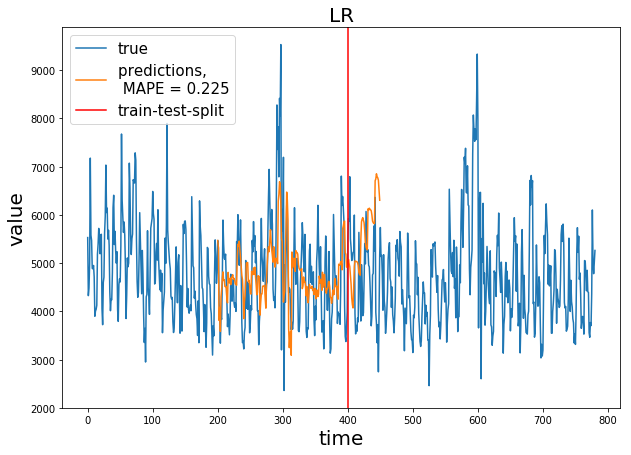

In [14]:
description = "LR"
plot_results(ts,Time,predict_in_sample,test_prediction,ts_test,description)

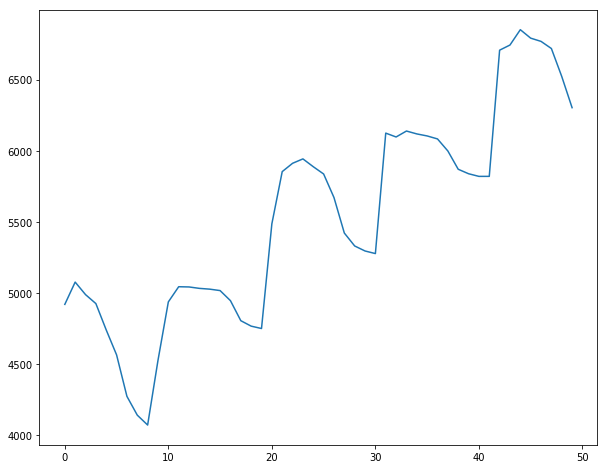

In [15]:
plt.figure(figsize=(10,8))
plt.plot(test_prediction)
plt.show()

## With lags

In [16]:
model_with_lags, last_with_lags, predict_in_sample_lags = fit_rolling_lr(ts_train,my_dict_of_features,with_lag=True)

In [17]:
test_prediction_with_lags = predict_rolling_lr(model_with_lags,last_with_lags,ts_train,forecast_horizont=end_point-middle_point,
                                     with_lag=True, my_dict_of_features = my_dict_of_features)

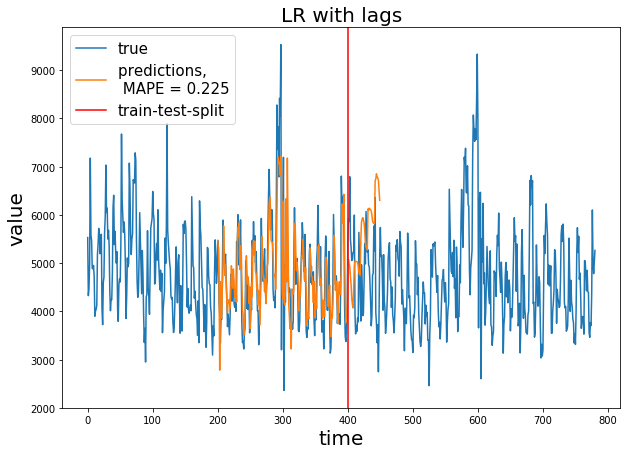

In [18]:
description = "LR with lags"
plot_results(ts,Time,predict_in_sample_lags,test_prediction,ts_test,description)

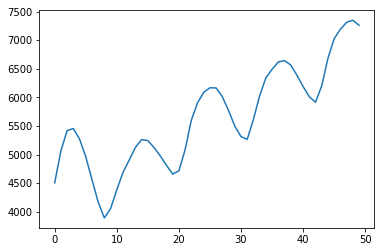

In [24]:
plt.plot(test_prediction_with_lags)